# 자치구와 고장의 연관성 분석

<br>
<br>

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
df_log = [None] * 13
df_log[7] = pd.read_csv("서울특별시 공공자전거 대여이력 정보_2207.csv")
df_log[8] = pd.read_csv("서울특별시 공공자전거 대여이력 정보_22081.csv")
df_log[9] = pd.read_csv("서울특별시 공공자전거 대여이력 정보_2209.csv")
df_log[10] = pd.read_csv("서울특별시 공공자전거 대여이력 정보_2210.csv")
df_log[11] = pd.read_csv("서울특별시 공공자전거 대여이력 정보_2211.csv")
df_log[12] = pd.read_csv("서울특별시 공공자전거 대여이력 정보_2212.csv")

In [3]:
df_rent = pd.read_csv("training_data7~12.csv")
df_office = pd.read_csv("공공자전거 대여소 정보(22.12월 기준).csv")
df_office.head()

,대여소 번호,자치구
0,301,종로구
1,302,종로구
2,303,종로구
3,305,종로구
4,307,종로구


In [4]:
df_region = df_office[['대여소 번호', '자치구']]
df_rentlog = pd.merge(df_rent, df_region, how='left', left_on='대여 대여소번호', right_on='대여소 번호')
df_rentlog.drop('대여소 번호', axis=1, inplace=True)
df_rentlog.dropna(subset=['자치구'], inplace=True)
df_rentlog.shape

(26267, 17)

In [5]:
region = None
first_flag = False
df_merged = [None] * 13
for i in range(7, 13):
    df_merged[i] = pd.merge(df_log[i], df_region, how='left', left_on='대여 대여소번호', right_on='대여소 번호')
    grouped = df_merged[i].groupby('자치구')
    # 각 그룹 개수 구하기
    if not first_flag:
        first_flag = True
        region = grouped.size()
    else:
        region += grouped.size()
print("자치구별 대여이력 총 개수")
print(region)

자치구별 대여이력 총 개수
자치구
강남구     181902
강동구     281246
강북구      87791
강서구     735883
관악구     162749
광진구     295536
구로구     241893
금천구     108377
노원구     365976
도봉구     128638
동대문구    216157
동작구     133723
마포구     315973
서대문구    125416
서초구     186038
성동구     235105
성북구     151187
송파구     568542
양천구     376266
영등포구    510840
용산구     125308
은평구     164215
종로구     222683
중구      150239
중랑구     177650
dtype: int64


In [6]:
broken_count = df_rentlog.groupby('자치구')['고장'].sum()
total_count = df_rentlog['자치구'].value_counts()
broken_ratio = broken_count / region * 100

평균과의차이 = (broken_ratio - broken_ratio.mean()) / broken_ratio.mean() * 100
print("(자치구고장비율-평균고장비율)/평균고장비율")
평균과의차이

(자치구고장비율-평균고장비율)/평균고장비율


자치구
강남구      5.375458
강동구     -7.704864
강북구     -6.351924
강서구    -15.141222
관악구      3.870353
광진구    -13.105307
구로구      9.601738
금천구     11.232637
노원구    -23.267416
도봉구    -10.595595
동대문구    -1.280824
동작구     -3.978710
마포구      8.317115
서대문구    23.004889
서초구      4.522379
성동구      3.139801
성북구      7.231287
송파구     -3.975120
양천구     -2.410970
영등포구    -5.063492
용산구     14.264611
은평구      3.786865
종로구     -1.062674
중구       7.293051
중랑구     -7.702063
dtype: float64

In [ ]:
!pip install geopandas matplotlib mapclassify

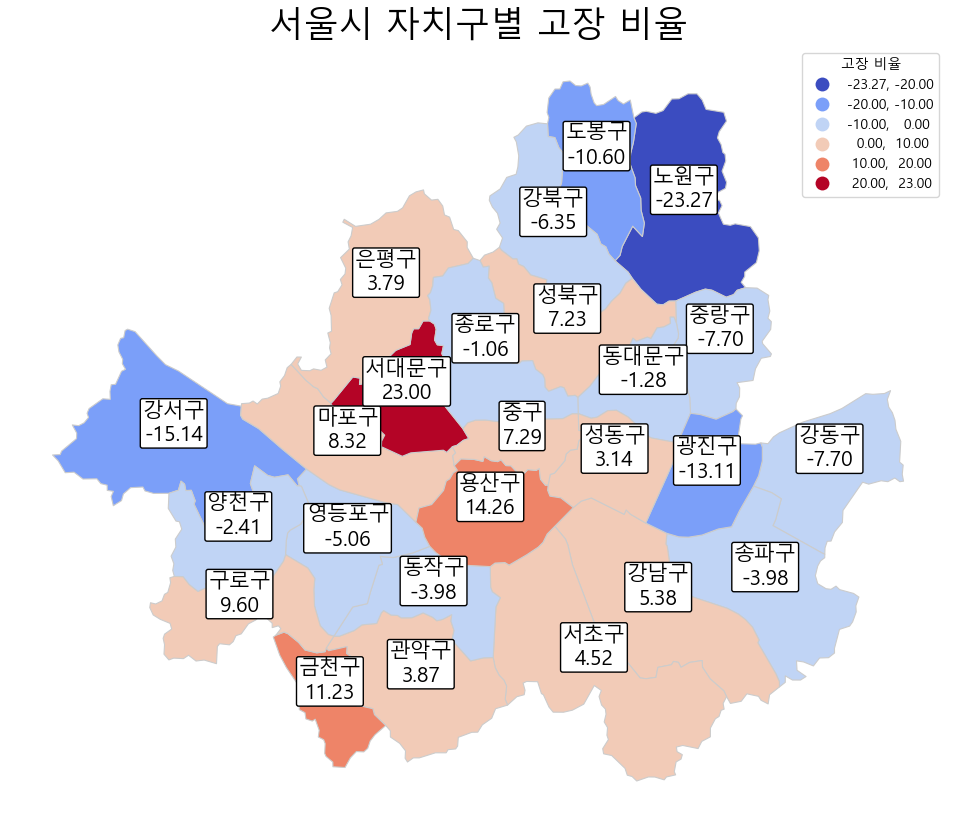

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify

# fault_ratio 데이터프레임의 열 이름 고치기
fault_ratio = pd.DataFrame(평균과의차이).reset_index()
fault_ratio.columns = ['자치구', '고장비율']

# 서울시 자치구 경계 데이터
url = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
seoul_districts = gpd.read_file(url)

# fault_ratio 데이터프레임와 서울 자치구 데이터 병합
merged_data = seoul_districts.set_index('name').join(fault_ratio.set_index('자치구'))

# 속성별 지도 그리기
fig, ax = plt.subplots(1, figsize=(15, 10))
bins = [-20, -10, 0, 10, 20]
merged_data.plot(column='고장비율', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax, scheme='userdefined', classification_kwds={'bins': bins}, missing_kwds={'color': 'lightgrey', "label": "Missing values"}, legend_kwds={'title': '고장 비율', 'fmt': '{:.2f}'})

# 자치구 이름과 고장 비율 표시
for idx, row in merged_data.iterrows():
    plt.annotate(text=f"{idx}\n{row['고장비율']:.2f}", xy=row['geometry'].centroid.coords[0], horizontalalignment='center', fontsize=15, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

ax.axis('off')
ax.set_title('서울시 자치구별 고장 비율', fontsize=25)
plt.show()


## 분석 결과

서울시의 25개의 자치구의 평균 고장비율 대비 각각의 고장비율을 분석했습니다.

예상보다 자치구에 따라 편차가 컸습니다.

**고장 비율이 평균보다 10%이상 높은 자치구는 '서대문구', '용산구', '금천구' 입니다.**

**고장 비율이 평균보다 10%이상 낮은 자치구는 '도봉구', '노원구', '강서구', '광진구' 입니다.